<a href="https://colab.research.google.com/github/rashidkisejjere0784/ENGLISH-TO-LUGANDA-WITH-ATTENTION-MECHANISM-/blob/main/English_to_Luganda_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "tensorflow-text>=2.10"
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 13.7 MB/s 
     |████████████████████████████████| 588.3 MB 20 kB/s 
     |████████████████████████████████| 1.7 MB 59.9 MB/s 
     |████████████████████████████████| 439 kB 73.4 MB/s 
     |████████████████████████████████| 6.0 MB 62.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [ ]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv("Luganda (1).csv", encoding = "ISO-8859-1")
data = data[["English", "Luganda"]]
data = data.dropna()

context_raw = data["English"]
target_raw = data["Luganda"]

In [ ]:
data.tail()

,English,Luganda
15017,Senior officials exaggerated the numbers to mi...,Abakungu ab'oku ntikko baayongeza omuwendo okw...
15018,There is a high risk in the spread of diseases...,Akatyabaga k'okusaasaana kw'endwadde mu nkambi...
15019,They were relocated to another settlement camp.,Baasengulwa ne batwalibwa mu nkambi endala.
15020,Some people who flee from South Sudan already ...,Abantu abamu abava mu South Sudan balina ab'en...
15021,The district officer has advised the people to...,Omukungu wa disitulikiti awadde abantu amagezi...


In [ ]:
!pip install wordcloud matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
text = " ".join(cat.split()[1] for cat in context_raw)

In [ ]:
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

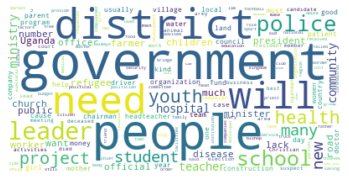

In [ ]:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
text1 = " ".join(cat for cat in target_raw)

In [ ]:
word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(text1)

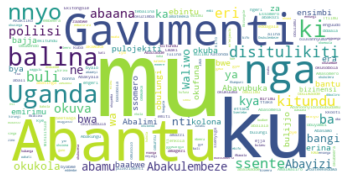

In [ ]:
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

Tokenizing the text for visualization

In [ ]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [ ]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'People still go to crowded places.'
 b'Youth are advised not to give up on their goals.'
 b'People lack income for electric transmission.'
 b'Uganda has several refugee camps in the Northern region.'
 b'Wishing someone a good holiday just shows you care.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Abantu na kati bakyagenda mu bifo ebirimu abantu abangi.'
 b'Abavubuka bakubiriziddwa obutava ku biruubirirwa byabwe.'
 b'Abantu tebalina ssente za kusika masannyalaze.'
 b"Uganda erina enkambi z'abanoonyiboobubudamu ez'enjawulo mu bukkikakkono."
 b'Okwagaliza omuntu oluwummula olulungi kiraga nti ofaayo.'], shape=(5,), dtype=string)


In [ ]:
example_text = tf.constant('Uganda balina emikolo')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'Uganda balina emikolo'
b'Uganda balina emikolo'


In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

Converting a given text into numerical and reconvert itback into text

In [ ]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Uganda balina emikolo
[START] uganda balina emikolo [END]


Text Vectorization

In [ ]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['', '[UNK]', '[START]', '[END]', '.', 'the', 'to', 'in', 'of', 'a']

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'mu', 'ku', 'abantu', '?', 'gavumenti']

In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 12, 220, 238, 6, 4350, 500, 4, 3],
 [2, 104, 10, 125, 29, 6, 312, 85, 23, 19, 1271, 4, 3],
 [2, 12, 134, 215, 13, 1828, 2905, 4, 3]]>

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] people still go to crowded places . [END]'

Text(0.5, 1.0, 'Mask')

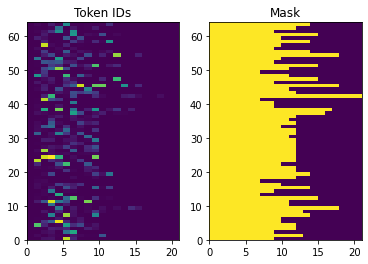

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

Distribution of the sequence length

In [ ]:
import seaborn as sns

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


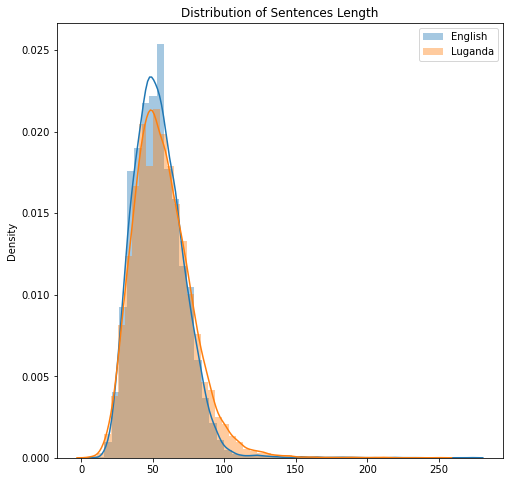

In [ ]:
plt.figure(figsize = (8,8))
sns.distplot([len(x) for x in context_raw], label='English')
sns.distplot([len(x) for x in target_raw], label='Luganda')
plt.title('Distribution of Sentences Length')
plt.legend()
plt.show()

Word Count Visualization

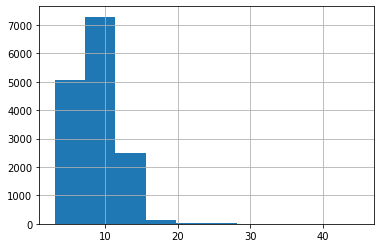

In [ ]:
context_raw.apply(lambda x: len(str(x).split())).hist()

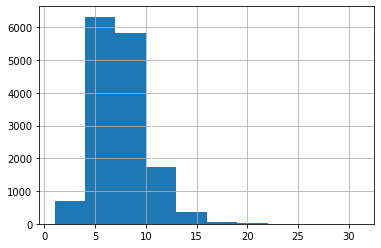

In [ ]:
target_raw.apply(lambda x: len(str(x).split())).hist()

Unique Word Count in the dataset

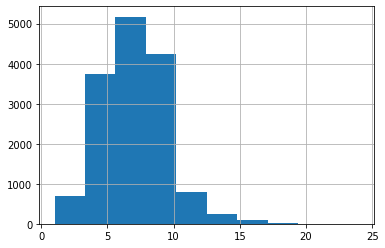

In [ ]:
target_raw.apply(lambda x: len(set(str(x).split()))).hist()

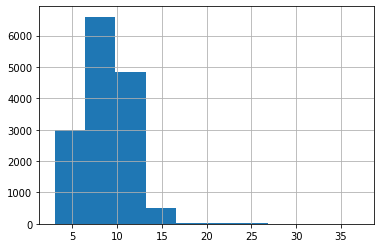

In [ ]:
context_raw.apply(lambda x: len(set(str(x).split()))).hist()

Create the Vectorized dataset

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[   2  392   23 3687   16 1023  545   58   17   50]

[   2  350    1 1138    6 2675    1   18    6  948]
[ 350    1 1138    6 2675    1   18    6  948    1]


In [ ]:
english_tokens = ex_tar_in.numpy()

In [ ]:
english_tokens

array([[   2,  350,    1, 1138,    6, 2675,    1,   18,    6,  948,    1,
           4,    0,    0,    0],
       [   2,   61,   78, 4430,    5, 2684,   23,   52,    4,    0,    0,
           0,    0,    0,    0],
       [   2,  209, 2857,   13,    5,  134,    8,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   2, 1299, 3901,    1,  178, 1645,  562,    5,   19,    4,    0,
           0,    0,    0,    0],
       [   2,  268,  263, 1410,  166,    4,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   2,  524,    1,    1,    4,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   2,  103, 4145,  588,  651,  100, 2329,    1,    4,    4,    0,
           0,    0,    0,    0],
       [   2,   72,  802,   11,    1,   62,    1,    4,    0,    0,    0,
           0,    0,    0,    0],
       [   2,    7,    1, 2543, 1611, 1513,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   2,    1,  152,    1, 1492,

In [ ]:
corr = pd.DataFrame(english_tokens).corr()

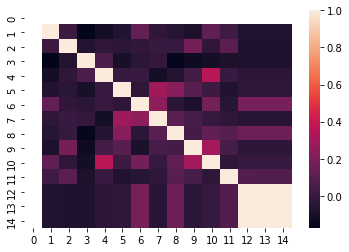

In [ ]:
sns.heatmap(corr)

In [ ]:
luganda_tokens = ex_tar_out.numpy()

Colleration matrix

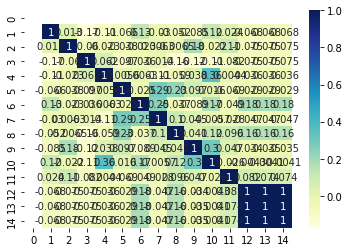

In [ ]:
dataplot = sns.heatmap(pd.DataFrame(english_tokens).corr(), cmap="YlGnBu", annot=True)

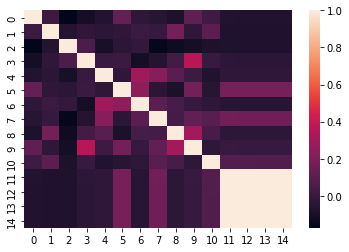

In [ ]:
sns.heatmap(pd.DataFrame(luganda_tokens).corr())

Box Plot 

{'whiskers': [<matplotlib.lines.Line2D at 0x7f59e4474eb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f59e44075b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f59e4474b50>,
 'medians': [<matplotlib.lines.Line2D at 0x7f59e4407c70>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f59e4407f70>,
 'means': []}

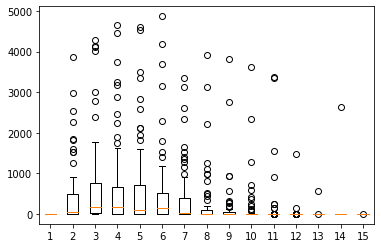

In [ ]:
plt.boxplot(english_tokens)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f59df620af0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f59df620f40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f59df6209d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f59df6b0160>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f59df6b0580>,
 'means': []}

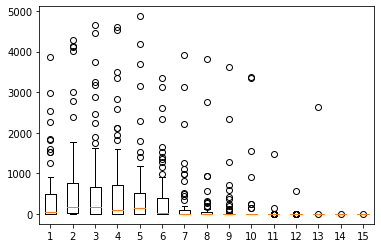

In [ ]:
plt.boxplot(luganda_tokens)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


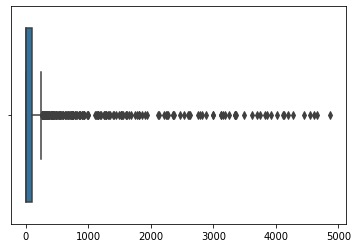

In [ ]:
sns.boxplot(english_tokens)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2112: FutureWarning: Using `vertical=True` to control the orientation of the plot  is deprecated. In

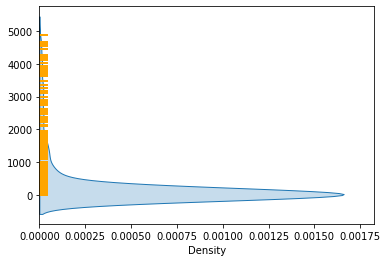

In [ ]:
sns.distplot(english_tokens, kde=True, vertical=True, rug=True, hist=False, kde_kws=dict(shade=True), rug_kws=dict(lw=2, color='orange'))

In [ ]:
UNITS = 256

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 18)
Encoder output, shape (batch, s, units): (64, 18, 256)


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 18, 256)
Target sequence, shape (batch, t, units): (64, 15, 256)
Attention result, shape (batch, t, units): (64, 15, 256)
Attention weights, shape (batch, t, s):    (64, 15, 18)


In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ],
      dtype=float32)

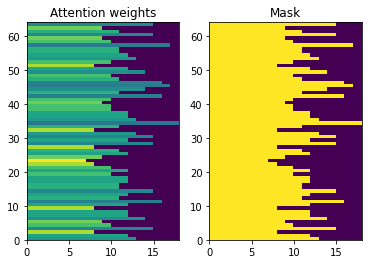

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 18, 256)
input target tokens shape: (batch, t) (64, 15)
logits shape shape: (batch, target_vocabulary_size) (64, 15, 5000)


In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'ekikola omwavu yessomero okunogera yokukwatamu obuvunaanyibwa okuli egyokufuna yeetegese olwokufa',
       b'gano byebyokwerinda kukola yabawadde yamba mbalama lyebisolo zebitundu bazimba okweyagaliza',
       b'zitumbula obuvunaanyizibwa ezobulamu omuto lwonna okusigala gyekkanisa bwekibumba ebyokukozesa yomusolo'],
      dtype=object)

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 18)
Target tokens, shape: (batch, t) (64, 15)
logits, shape: (batch, t, target_vocabulary_size) (64, 15, 5000)


In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 9s 29ms/step - loss: 8.5210 - masked_acc: 1.7424e-04 - masked_loss: 8.5210


{'loss': 8.520994186401367,
 'masked_acc': 0.00017423505778424442,
 'masked_loss': 8.520994186401367}

In [ ]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
100/100 [==============================] - 30s 163ms/step - loss: 5.5709 - masked_acc: 0.2711 - masked_loss: 5.5709 - val_loss: 4.6712 - val_masked_acc: 0.3523 - val_masked_loss: 4.6712
Epoch 2/100
100/100 [==============================] - 9s 85ms/step - loss: 4.6265 - masked_acc: 0.3540 - masked_loss: 4.6258 - val_loss: 4.1373 - val_masked_acc: 0.4004 - val_masked_loss: 4.1373
Epoch 3/100
100/100 [==============================] - 6s 57ms/step - loss: 3.8783 - masked_acc: 0.4179 - masked_loss: 3.8783 - val_loss: 3.6408 - val_masked_acc: 0.4394 - val_masked_loss: 3.6408
Epoch 4/100
100/100 [==============================] - 6s 59ms/step - loss: 3.3439 - masked_acc: 0.4645 - masked_loss: 3.3438 - val_loss: 3.2268 - val_masked_acc: 0.4799 - val_masked_loss: 3.2268
Epoch 5/100
100/100 [==============================] - 5s 52ms/step - loss: 2.6693 - masked_acc: 0.5285 - masked_loss: 2.6693 - val_loss: 2.9533 - val_masked_acc: 0.5055 - val_masked_loss: 2.9533
Epoch 6/100
100/10

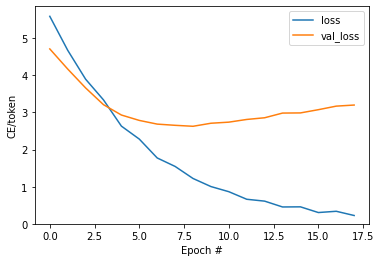

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

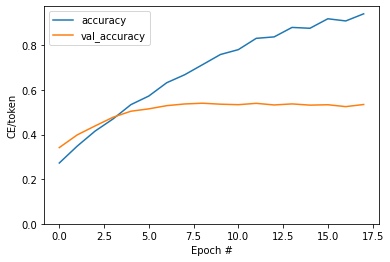

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
result = model.translate(['Projects are helping with the planting of trees in the Northern part of Uganda.']) # Are you still home
result[0].numpy().decode()

'pulojekiti ziyamba mu kusimba emiti mu bukiikakkono bwa uganda . '

In [ ]:
result = model.translate(['Pupils are performing well in the primary leaving examinations.']) # Are you still home
result[0].numpy().decode()

'abayizi bakola obulungi mu bibuuzo byakamalirizo [UNK] [UNK] ebigezo byakamalirizo ? '

In [ ]:
result = model.translate(['i am going to school today']) # Are you still home
result[0].numpy().decode()

'ngenda ku ssomero leero . '

CPU times: user 295 ms, sys: 4.87 ms, total: 300 ms
Wall time: 293 ms


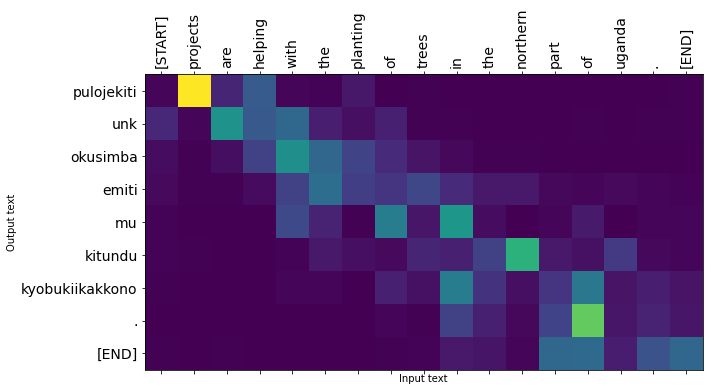

In [ ]:
%%time
# This is my life.
model.plot_attention('Projects are helping with the planting of trees in the Northern part of Uganda.')

In [ ]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

In [ ]:
inputs = context_raw[:10]

In [ ]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

abanoonyiboobubudamu bonna baasabiddwa [UNK] ewa ssentebe . 
[UNK] [UNK] [UNK] eggulo . 
abanoonyiboobubudamu bafunye [UNK] wakati wa bannannyini ttaka . 
[UNK] [UNK] abanoonyiboobubudamu mu bitundu byaffe . 
bwe tukolera awamu [UNK] [UNK] [UNK] . 
disitulikiti eziriraanye ensalo si ntebenkevu . 
abanoonyiboobubudamu batandise okulima okusobola okwebeezaawo . 
kimenya mateeka okubeera nemmundu . 
[UNK] nnyo bazadde be kitiibwa . 
[UNK] nnyo . 

CPU times: user 2.36 s, sys: 42.6 ms, total: 2.4 s
Wall time: 2.32 s


In [ ]:
target_raw[:10]

0    Abanoonyiboobubudamu bonna baasabiddwa beewand...
1    Baayise olukungaana lw'abanoonyiboobubudamu eg...
2    Abanoonyiboobubudamu b'abadde n'obutakkaanya w...
3    Twakubirizibwa okwaniriza abanoonyiboobubudamu...
4    Bwe tukolera awamu enkulaakulana enyingi efuni...
5       Disitulikiti eziriraanye ensalo si ntebenkevu.
6    Abanoonyiboobubudamu batandise okulima okusobo...
7                  Kimenya mateeka okubeera n'emmundu.
8                        Awa nnyo bazadde be kitiibwa.
9                         Omusajja anywa nnyo omwenge.
Name: Luganda, dtype: object

In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [ ]:
export = Export(model)

In [ ]:
%%time
_ = export.translate(tf.constant(inputs))

CPU times: user 1min 8s, sys: 2.32 s, total: 1min 10s
Wall time: 1min 13s


In [ ]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

abanoonyiboobubudamu bonna baasabiddwa [UNK] ewa ssentebe .                                           
[UNK] [UNK] [UNK] eggulo .                                             
abanoonyiboobubudamu bafunye [UNK] wakati wa bannannyini ttaka .                                          

CPU times: user 139 ms, sys: 12.6 ms, total: 152 ms
Wall time: 126 ms


In [ ]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

CPU times: user 1min 33s, sys: 3.9 s, total: 1min 37s
Wall time: 1min 36s


In [ ]:
%%time
reloaded = tf.saved_model.load('./drive/MyDrive/translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

CPU times: user 54.8 s, sys: 3.37 s, total: 58.1 s
Wall time: 1min 3s


In [ ]:
reloaded.translate(["I am going to school"])

<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'ngenda ku ssomero .                                              '],
      dtype=object)>